In [1]:
"""
This script visualizes the LiveOcean model domain, including:
- Bathymetry and coastline from the model grid
- Observational bottle data locations
- Mooring and long-term monitoring station coordinates

Required inputs:
- NetCDF grid file (with h, lon_rho, lat_rho, mask_rho)
- Coastline data
- Pickled bottle data files for multiple sources and years
"""

'\nThis script visualizes the LiveOcean model domain, including:\n- Bathymetry and coastline from the model grid\n- Observational bottle data locations\n- Mooring and long-term monitoring station coordinates\n\nRequired inputs:\n- NetCDF grid file (with h, lon_rho, lat_rho, mask_rho)\n- Coastline data\n- Pickled bottle data files for multiple sources and years\n'

In [2]:
"""
import packages
"""
import pandas as pd
import numpy as np
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
from cmcrameri import cm
"""
LiveOcean module
"""
from lo_tools import plotting_functions as pfun
from lo_tools import Lfun
# to block warning about pickle file loading
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
"""
load the LiveOcean grid
"""

# get the grid file
Ldir = Lfun.Lstart()
gridname = 'cas2k'  # cascadia 2 kilometers
in_dir = Ldir['LOo'] / 'pgrid' /gridname   # directory
in_fn = in_dir/'grid.nc'  # file
# define figure output directory
fig_dir = Ldir['LOo']/'plots'/'map'
# define figure output directory
Lfun.make_dir(fig_dir,clean= False)
# load the data
ds = xr.open_dataset(in_fn)
# read variables 
z = -ds.h.values  # bathymetry
mask_rho = ds.mask_rho.values  # 0 for land, 1 for ocean
# make a version of z with land being masked with nans
zm = z.copy()
zm[mask_rho == 0] = np.nan
# coordinates
lon = ds.lon_rho.values
lat = ds.lat_rho.values
plon, plat = pfun.get_plon_plat(lon,lat)
# pad = 0.05*(plat[-1,0]-plat[0,0])
pad = 0.0*(plat[-1,0]-plat[0,0])
ax_lims = (plon[0,0]-pad, plon[0,-1]+pad, plat[0,0]-pad, plat[-1,0]+pad)


In [4]:
"""
get all the bottle datasets that all have carbon variables
e.g., DIC, alkalinity
"""

bottle = True
WCOA = True
WOD = True
nceiPNW = True

df= pd.DataFrame() # empty dataframe then append each dataset
if WCOA:    
    year_list = [2007, 2011, 2012, 2013, 2016, 2017, 2021]
    for year in year_list:
        in_dir = Ldir['LOo'] / 'obs' /'nceiCoastal'/'bottle'
        in_fn = in_dir / ('info_' + str(year) + '.p')
        df0 = pickle.load(open(in_fn, 'rb'))
        df = pd.concat([df, df0])  # Concatenate df0 into df
if WOD:    
    year_list = list(np.arange(1993, 2011))
    for year in year_list:
        in_dir = Ldir['LOo'] / 'obs' /'WOD'/'bottle'
        in_fn = in_dir / ('info_' + str(year) + '.p')
        df0 = pickle.load(open(in_fn, 'rb'))
        df = pd.concat([df, df0])  # Concatenate df0 into df

if nceiPNW:    
    year_list = list(np.arange(1993, 2009)) + [2010] + list(np.arange(2013, 2018))
    for year in year_list:
        in_dir = Ldir['LOo'] / 'obs' /'nceiPNW'/'bottle'
        in_fn = in_dir / ('info_' + str(year) + '.p')
        df0 = pickle.load(open(in_fn, 'rb'))
        df = pd.concat([df, df0])  # Concatenate df0 into df    
        
fil_dict = dict()  # dict to hold filter choices
# Set mask_salish to True to ignore stations in the Salish Sea
fil_dict['mask_salish'] = True 
if fil_dict['mask_salish']:
    a = df.copy()
    mask1 = (a.lat >= 46) & (a.lat < 49) & (a.lon > -124.5)
    mask2 = (a.lat >= 49) & (a.lat < 51) & (a.lon > -125)
    mask3 = (a.lat >= 49.5) & (a.lat < 52) & (a.lon > -126)
    mask4 = (a.lat >= 50) & (a.lat < 52) & (a.lon > -128.5)
    mask5 = (a.lat >= 48.5) & (a.lat < 49.5) & (a.lon > -125.5)
    mask6 = (a.lat >= 49) & (a.lat < 51) & (a.lon > -126.5)
    mask7 = (a.lat >= 51) & (a.lat < 52) & (a.lon > -128) & (a.lon < -126.5)
    a = a.loc[(~mask1) & (~mask2) & (~mask3) & (~mask4) & (~mask5) & (~mask6) & (~mask7), :]            

df = a.copy()

In [5]:
"""
get all the moorings coordinates
"""
OCNMS_dict = {
    'CA15': [-124.7568, 48.1663],
    'CA42': [-124.8234, 48.1660],
    'CA65': [-124.8949, 48.1659],
    'CE15': [-124.3481, 47.3568],
    'CE42': [-124.4887, 47.3531],
    'CE65': [-124.5669, 47.3528],
    # 'KL15': [-124.4284, 47.6008], #no bottom DO
    'KL27': [-124.4971, 47.5946],   
    # 'MB15': [-124.6768, 48.3254], #no bottom DO
    'MB42': [-124.7354, 48.3240],
    # 'TH15': [-124.619467, 47.876117], # too short
    'TH42': [-124.733417, 47.875817],
}

 # NOAA PMEL moor
PMEL_dict = {

    'CapeElizabeth': [-124.731, 47.353],
    'Chaba':         [-125.958, 47.936],
    # discard   #'NH10':          (-124.778, 44.904), # not accurate based on https://www.pmel.noaa.gov/co2/timeseries/NH10.txt
    'NH10':          [-124.301, 44.642], # from https://www.pmel.noaa.gov/co2/story/NH-10
    'CapeArago':     [-124.530, 43.300], # https://www.pmel.noaa.gov/co2/story/CB-06
    #'Dabob':         [-122.803, 47.803],
    # 'Twanoh':        [-123.008, 47.375]
}

 # Ocean Observation Initiative on the west coast
OOI_dict = {

    'CE01ISSM': [-124.09583, 44.65978], # MFN btm 25m
    'CE02SHSM': [-124.3032, 44.63532], # RID surf 7m
    # 'CE02SHBP': [-124.30572, 44.63721], # cabled benthic package at OR shelf btm 80m
    #'CE04OSBP': [-124.95351, 44.36926], # cabled benthic package at OR offshore btm 581m
    'CE04OSSM': [-124.9398, 44.36518], # RID surf 7m
    'CE06ISSM': [-124.26973, 47.13365], # MFN btm 29m
    'CE07SHSM': [-124.55202, 46.98472], # MFN btm 87m 
    'CE09OSSM': [-124.9509, 46.85343] # MFN btm 540m

}

In [6]:
"""
get the coordinates from long-term monitoring program
"""
# 
LineP_dict = {

    'P01': [-125.5000, 48.5750],  # 120 m
    'P02': [-126.0000, 48.6000],  # 114 m
    'P03': [-126.3333, 48.6250],  # 750 m
    'P04': [-126.6667, 48.6500],  # 1300 m
    'P05': [-127.1667, 48.6917],  # 2100 m
    'P06': [-127.6667, 48.7433],  # 2500 m
    'P07': [-128.1667, 48.7767],  # 2450 m
    'P08': [-128.6667, 48.8167],  # 2440 m
    'P09': [-129.1667, 48.8567],  # 2340 m
    'P10': [-129.6667, 48.8933],  # 2660 m
    #'P11': [-130.1667, 48.9333],  # 2700 m
    #'P12': [-130.6667, 48.9700]  # 3300 m # this is out of model domain
}

P4_dict = {

    'P04': [-126.6667, 48.6500],  # 1300 m

}

# Newport Hydrography Line
NHL_dict = {
    'NH01': [-124.100, 44.652],  # 30 m
    'NH03': [-124.130, 44.652],  # 48 m
    'NH05': [-124.177, 44.652],  # 60 m
    'NH10': [-124.295, 44.652],  # 81 m
    'NH15': [-124.412, 44.652],  # 90 m
    'NH20': [-124.528, 44.652],  # 140 m
    'NH25': [-124.650, 44.652],  # 296 m
    'NH35': [-124.880, 44.652],  # 452 m
    'NH45': [-125.120, 44.652],  # 500 m
    'NH65': [-125.600, 44.652],  # 1000 m

}

GHL_dict = {

    'GH01': [-124.2470, 47.1151],
    'GH02': [-124.3820, 47.1151],
    'GH03': [-124.5001, 47.1151],
    'GH04': [-124.6371, 47.1151],
    'GH05': [-124.3481, 47.1151],
    'GH06': [-124.7370, 47.1151],
    'GH07': [-124.8197, 47.1151],
    'GH08': [-124.9820, 47.1151], 
    'GH09': [-125.0553, 47.1151],
    'GH10': [-125.1901, 47.1151], 
    # 'GH11': [-126.0850, 47.1151], 
               }

In [7]:
# set up the symbols and colors 
source_list = ['PMEL','P4','OCNMS', 'NHL', 'GHL','LineP', 'OOI']
color = ['#FFFF00','#FF00FF','g','#FF00FF','b','#FF00FF','r']
marker =['s','s', 'o','-o','-o','-^','*']
# manipulate the colormap for the bathymetry to 
# keep the ocean-segment only, as the colormap covers the land topography as well. 
cmap = cm.bukavu
fraction = 0.4999
n_colors = int(fraction * cmap.N)  # Number of colors to keep
new_colors = cmap(np.linspace(0, fraction, n_colors))  # Select the colors
# Create the new colormap
new_cmap = mcolors.ListedColormap(new_colors)

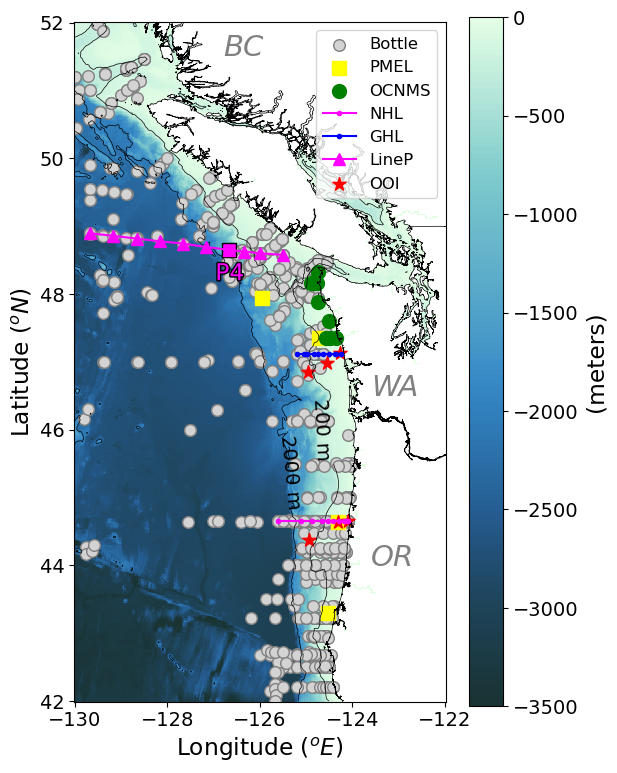

In [8]:
# PLOTTING
plt.close('all')
small = True
fs = 14
if small:
    figsize = (6,8)
else:
    figsize = (12,12)
pfun.start_plot(figsize=figsize)
# bathymetry
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.pcolormesh(plon, plat, zm, vmin=-3500, vmax=0, cmap=new_cmap)
# cs = ax.pcolormesh(plon, plat, zm, vmin=zmin, vmax=0, cmap='Blues_r') # 'gist_earth'
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label(label='(meters)', fontsize=fs*1.2)

pfun.add_bathy_contours(ax, ds, txt=True)  # add coastline
pfun.add_coast(ax) # add bathymetry contour
pfun.dar(ax)

# Add data sources
if bottle:
    ax.scatter(df['lon'], df['lat'], c='lightgray', marker= 'o', s=70, edgecolors='gray', linewidths=1, label= 'Bottle')
# add moorings and long-term monitoring program    
ii = 0
for source in source_list:    
    source_dict = globals().get(f'{source}_dict')    
    if source_dict:  # Check if the dictionary exists
        loc = list(source_dict.values())  # Extract coordinates
        sn_list = list(source_dict.keys())  # Extract station names
        lon, lat = zip(*loc)  # Separate longitude and latitude
        lon = np.array(lon)
        lat = np.array(lat)
    if source == 'LineP':
        ax.plot(lon, lat, marker[ii], color=color[ii], markersize=8,
                markeredgecolor=color[ii], markeredgewidth=1, label=source)        
    elif  source == 'NHL' or source == 'GHL':        
        ax.plot(lon, lat, marker[ii], color=color[ii], markersize=3,
                markeredgecolor=color[ii], markeredgewidth=1, label=source)        
    elif source == 'P4':
        ax.scatter(lon, lat, c=color[ii], marker= marker[ii], s=110, edgecolors='k', linewidths=1, label= '')
        text = ax.text(.38, .62, 'P4', fontsize = fs*1.2, color = '#FF00FF',  transform=ax.transAxes)        
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    else:
        ax.scatter(lon, lat, c=color[ii], marker= marker[ii], s=100, edgecolors=color[ii], linewidths=1, label=source)
    ii += 1
plt.legend(loc='upper right', fontsize=fs*0.85)

ax.text(.8, .2, 'OR', fontsize=fs*1.5, color='gray', fontstyle='italic', transform=ax.transAxes)
ax.text(.8, .45, 'WA', fontsize = fs*1.5, color = 'gray',  fontstyle='italic', transform=ax.transAxes)
ax.text(.4, .95, 'BC', fontsize = fs*1.5, color = 'gray',  fontstyle='italic', transform=ax.transAxes)
ax.axis(ax_lims)
ax.set_xlabel('Longitude ($^{o}E$)', fontsize=fs*1.2)
ax.set_ylabel('Latitude ($^{o}N$)', fontsize=fs*1.2)

# plt.subplots_adjust(left=0.17, right=0.98, top=0.98, bottom=0.05)
plt.tight_layout()
fig.savefig(fig_dir/f'{gridname}_grid_map_Figure_01.png', bbox_inches='tight', dpi = 300)
plt.show()